In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'midasfpga')))

In [3]:
from dataset.custom_dataset import CustomDataset
from utils.metric import BadPixelMetric
from configs.midas_config import Midas_Config
from utils.func_utils import get_midas_transform, get_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as data
import torch.nn.functional as F
import torch
import time

conf = Midas_Config()
conf.MODEL_WEIGHTS = os.path.join('..', 'midasfpga/weight/midas_v21_small_256.pt')

model, device = get_model(conf)

CPU = False
if CPU:
    device = torch.device('cpu')
    model = model.to(device)

model = model.eval().to(device)
transform = get_midas_transform()


loss1_saved = []
loss2_saved = []
loss3_saved = []
outputs = []

sure = 0
for partition_index in range(1):

    ds = CustomDataset(os.path.join('..', 'midasfpga/data'), transform=transform)
    dl = data.DataLoader(
        ds, batch_size=1, num_workers=1, shuffle=False, pin_memory=True
    )

    # validate
    metric = BadPixelMetric()

    loss_sum1 = 0
    loss_sum2 = 0
    loss_sum3 = 0

    duration = 0.0

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dl),total=len(dl.dataset)):
            image, depth, mask = batch['image'], batch['depth'], batch['mask']
            tstart = time.time()
            prediction = model(image.to(device)).cpu()
            duration += time.time() - tstart

            # resize prediction to match target
            prediction = F.interpolate(
                prediction.unsqueeze(0),
                size=batch["mask"].shape[1:],
                mode="bilinear",
                align_corners=False,
            )
            prediction = prediction.squeeze(1)

            loss1, loss2, loss3, pd, t, e = metric(prediction, batch["depth"].to(torch.float32), batch["mask"])

            loss_sum1 += loss1
            loss_sum2 += loss2
            loss_sum3 += loss3
        
    loss1_saved.append(loss_sum1.item() / len(ds))
    loss2_saved.append(loss_sum2.item() / len(ds))
    loss3_saved.append(loss_sum3.item() / len(ds))
    print(f"Partition_{partition_index} bad pixel percentage delta_1: {loss_sum1 / len(ds):.2f}")
    print(f"Partition_{partition_index} bad pixel percentage delta_2: {loss_sum2 / len(ds):.2f}")
    print(f"Partition_{partition_index} bad pixel percentage delta_3: {loss_sum3 / len(ds):.2f}")

print("Dataset bad pixel percentage delta_1: ", sum(loss1_saved)/len(loss1_saved))
print("Dataset bad pixel percentage delta_2: ", sum(loss2_saved)/len(loss2_saved))
print("Dataset bad pixel percentage delta_3: ", sum(loss3_saved)/len(loss3_saved))

print(f"Avg fps on {device}: {len(ds)/duration}")


Testing on cuda device.
Loading weights:  None


Using cache found in /home/yasin/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
100%|██████████| 6/6 [00:00<00:00,  6.96it/s]

Partition_0 bad pixel percentage delta_1: 11.95
Partition_0 bad pixel percentage delta_2: 0.87
Partition_0 bad pixel percentage delta_3: 0.27
Dataset bad pixel percentage delta_1:  11.947621663411459
Dataset bad pixel percentage delta_2:  0.8747514088948568
Dataset bad pixel percentage delta_3:  0.2654614845911662
Avg fps on cuda: 12.922747964599044


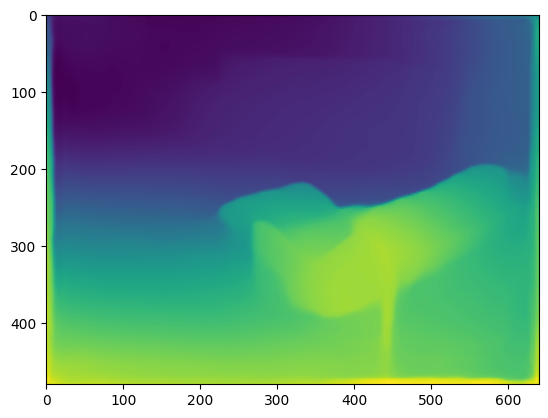

In [63]:
import matplotlib.pyplot as plt
plt.imshow(prediction.squeeze().cpu().numpy())